<a href="https://colab.research.google.com/github/davidsjohnson/evalxai_studies/blob/main/notebooks/two4two_sickones_training_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

from PIL import Image

torch.backends.cudnn.benchmark = True

In [9]:
torch.__version__

'2.5.1+cu121'

# Params

In [10]:
CLASSES = ['Healthy', 'OC Degeneration']

load_checkpoints = False
continue_training = False

modeltype = 'mobilenet'

ds = 'sick_ones_bendbias'

epochs = 10
learning_rate = 0.0001

# Setup and Load Datasets

In [11]:
relative_model_path = "two4two_sickones_models_pytorch"
base_path = Path('/content/drive/MyDrive') / relative_model_path
base_path

PosixPath('/content/drive/MyDrive/two4two_sickones_models_pytorch')

In [12]:
def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)

    return Path(file_path)

data_dir = download_file("https://uni-bielefeld.sciebo.de/s/AIJLvXMwP0ngEiW/download",
                         "two4two_datasets.tar.gz",
                         cache_dir='/content/data',
                         extract=True,
                         force_download=False,
                         archive_folder='two4two_datasets')
data_dir

File already exists at: /content/data/two4two_datasets.tar.gz
File extracted to: /content/data


PosixPath('/content/data/two4two_datasets')

## Load Dataset and Dataloaders


In [13]:
def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)
  return df

# prompt: create a torch dataloader from a pandas dataframe that contains paths to files
class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['ill'])

        if self.transform:
            image = self.transform(image)

        return image, label

# You can also define transforms for data augmentation or preprocessing here.
# For example:
# from torchvision import transforms
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
# train_dataset = ImageDataset(train_df, train_data_dir, transform=transform)

In [14]:
ds_dir = data_dir / ds
ds_dir

PosixPath('/content/data/two4two_datasets/sick_ones_bendbias')

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
])


train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')

train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                              num_workers=6, pin_memory=True)

val_dataset = ImageDataset(val_df,  ds_dir / 'validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                            num_workers=6, pin_memory=True)

test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

# Data Analysis

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

## Analysis Dataset

In [17]:
train_df['sphere_diff'] = np.abs(train_df['spherical'] - train_df['ill_spherical'])
val_df['sphere_diff'] = np.abs(val_df['spherical'] - val_df['ill_spherical'])
test_df['sphere_diff'] = np.abs(test_df['spherical'] - test_df['ill_spherical'])

### Training Data


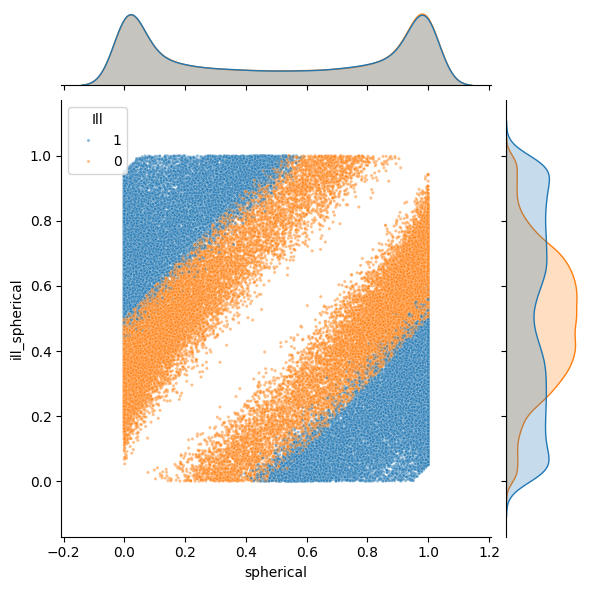

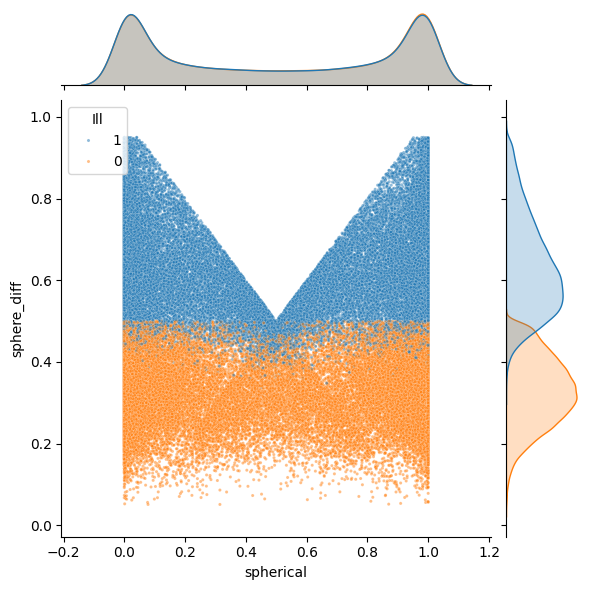

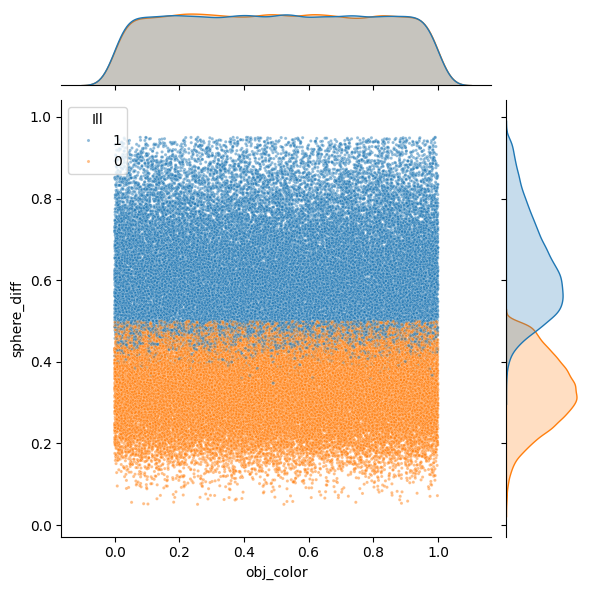

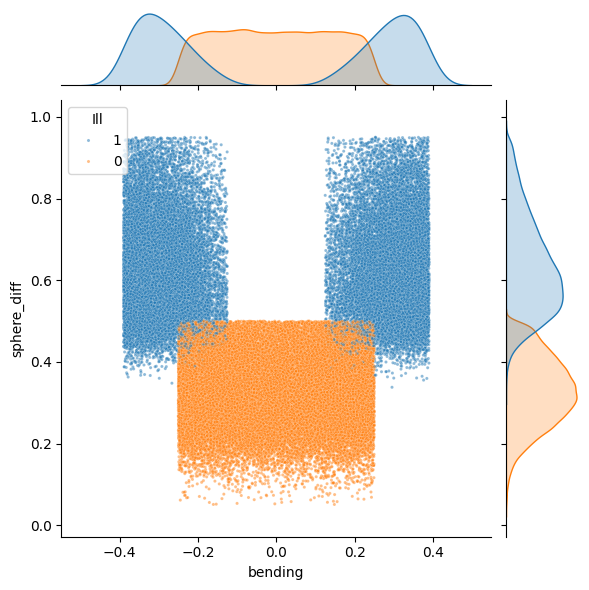

In [18]:
g =sns.jointplot(data=train_df, x='spherical', y='ill_spherical', hue='ill', s=5, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g =sns.jointplot(data=train_df, x='spherical', y='sphere_diff', hue='ill', s=5, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g = sns.jointplot(data=train_df, x='obj_color', y='sphere_diff', hue='ill', s=5, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g = sns.jointplot(data=train_df, x='bending', y='sphere_diff', hue='ill', s=5, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

### Test Data

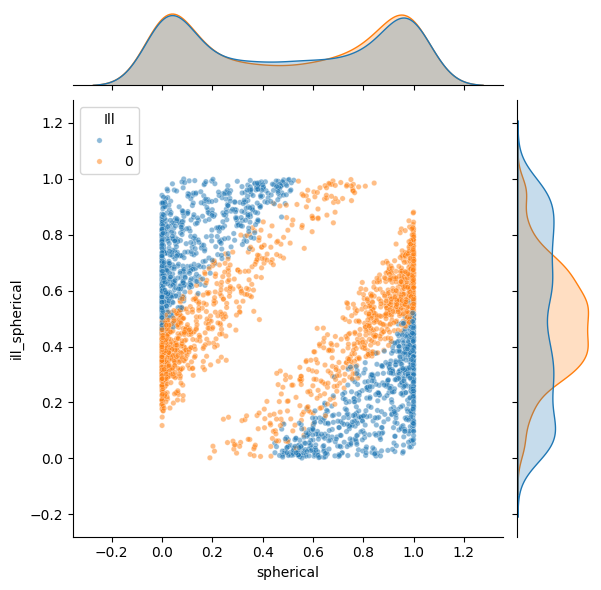

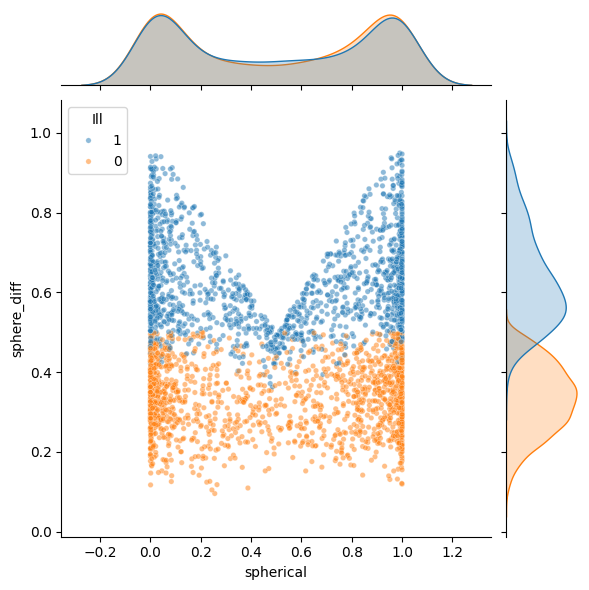

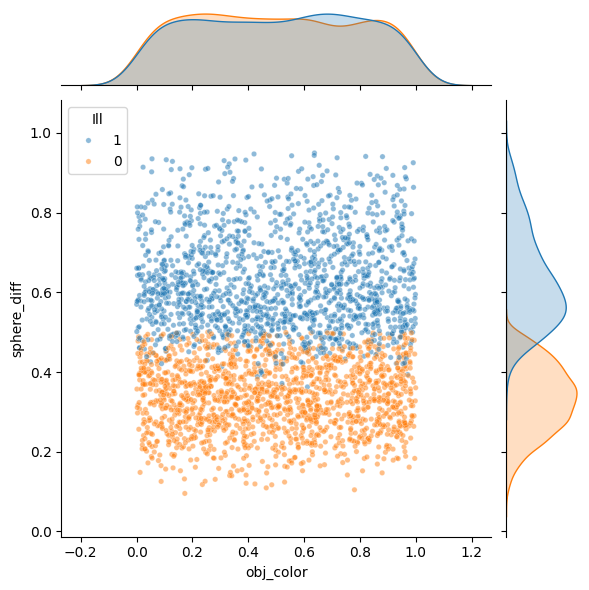

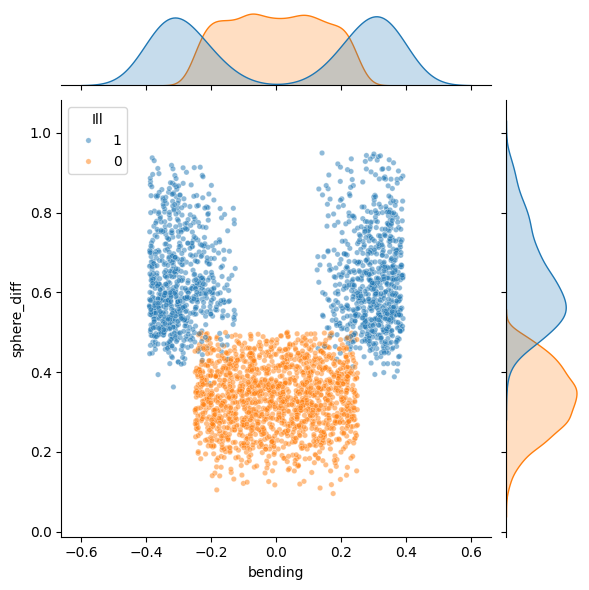

In [19]:
g =sns.jointplot(data=test_df, x='spherical', y='ill_spherical', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g =sns.jointplot(data=test_df, x='spherical', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g = sns.jointplot(data=test_df, x='obj_color', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)
g = sns.jointplot(data=test_df, x='bending', y='sphere_diff', hue='ill', s=15, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

# Model Training and Evaluation

In [20]:
model_path = base_path / ds / f'{modeltype}'
model_path.mkdir(parents=True, exist_ok=True)
model_path

PosixPath('/content/drive/MyDrive/two4two_sickones_models_pytorch/sick_ones_bendbias/mobilenet')

In [21]:
# prompt: pytorch code to load mobilenet v2 but include an option to load a checkpoint
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):
  """Loads a MobileNetV2 model, optionally loading from a checkpoint.

  Args:
    num_classes: The number of output classes.
    pretrained: Whether to load the pre-trained weights.
    checkpoint_path: Path to a checkpoint file to load.

  Returns:
    A MobileNetV2 model.
  """
  model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
  model.classifier[1] = nn.Linear(model.last_channel, num_classes)

  if checkpoint_path:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    print(f"Loaded checkpoint from: {checkpoint_path}")

  return model

In [22]:
def set_seed(seed):
  """
  Sets random seeds for reproducibility.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

def train_model(model, dl_train, dl_val, criterion, optimizer, scheduler, device, checkpoint_path, num_epochs=10):

  model = model.to(device)

  best_val_loss = sys.float_info.max

  for epoch in range(num_epochs):

    print(f"Epoch [{epoch+1}/{num_epochs}]")

    # Training phase
    model.train()

    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in dl_train:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        running_train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_train_loss / len(dl_train)
    train_accuracy = correct_train / total_train

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in dl_val:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track validation loss and accuracy
            running_val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(dl_val)
    val_accuracy = correct_val / total_val

    scheduler.step(val_loss)

    # Print epoch results
    print(f"\tTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"\tValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Checkpointing the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"New best model found at epoch {epoch+1} with validation loss: {val_loss:.4f}")
        torch.save(model.state_dict(), checkpoint_path / 'tmp' / 'best_model.pth')  # Save only the model's state_dict

  # To load the best model later:
  model = load_mobilenetv2(num_classes=len(CLASSES),
                           pretrained=False,
                           checkpoint_path=checkpoint_path / 'tmp' / 'best_model.pth')
  model.to(device)

  val_loss, val_acc = evaluate_model(model, dl_val, criterion, device)

  print(f"Training Run complete! Val loss = {best_val_loss:.4f} | Val acc = {val_acc:.4f}", )
  print("-" * 30)

  return model, val_loss, val_acc



## Train Model

In [23]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

checkpoint_path = model_path / "torch_mobilenetv2/"
(checkpoint_path / 'tmp').mkdir(parents=True, exist_ok=True)
(checkpoint_path / 'final').mkdir(parents=True, exist_ok=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
n_runs = 1
n_epochs = 10

best_val_loss = sys.float_info.max
for i in range(n_runs):

  set_seed(42 + i)

  print(f"Run {i+1} / {n_runs}")
  print("=" * 30)

  model = load_mobilenetv2(len(CLASSES), pretrained=False, checkpoint_path=None)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=True)

  # Scheduler
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=4,
                                                          threshold=0.01, threshold_mode='abs', verbose=True)

  model, val_loss, val_acc = train_model(model,
                                         train_dataloader, val_dataloader,
                                         criterion, optimizer, scheduler,
                                         device, checkpoint_path,
                                         num_epochs=n_epochs)

  # Checkpointing the best model
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      print(f"New best model found at Run {i+1} with validation loss: {val_loss:.4f}")
      torch.save(model.state_dict(), checkpoint_path / 'final' / 'best_model.pth')  # Save only the model's state_dict
  print()

# Load best model:
model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path / 'final' / 'best_model.pth')
model.to(device)

val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device)

print(f"Training complete! Val loss = {best_val_loss:.4f} | Val acc = {val_acc:.4f}", )
print("-" * 30)

Run 1 / 1
Epoch [1/10]
	Train Loss: 0.5792, Train Accuracy: 0.6652
	Validation Loss: 0.3598, Validation Accuracy: 0.8270
New best model found at epoch 1 with validation loss: 0.3598
Epoch [2/10]
	Train Loss: 0.3433, Train Accuracy: 0.8450
	Validation Loss: 0.3157, Validation Accuracy: 0.8540
New best model found at epoch 2 with validation loss: 0.3157
Epoch [3/10]
	Train Loss: 0.2950, Train Accuracy: 0.8658
	Validation Loss: 0.2928, Validation Accuracy: 0.8710
New best model found at epoch 3 with validation loss: 0.2928
Epoch [4/10]
	Train Loss: 0.2729, Train Accuracy: 0.8762
	Validation Loss: 0.3223, Validation Accuracy: 0.8610
Epoch [5/10]
	Train Loss: 0.2548, Train Accuracy: 0.8837
	Validation Loss: 0.2987, Validation Accuracy: 0.8690
Epoch [6/10]
	Train Loss: 0.2398, Train Accuracy: 0.8925
	Validation Loss: 0.3210, Validation Accuracy: 0.8600
Epoch [7/10]
	Train Loss: 0.2260, Train Accuracy: 0.8995
	Validation Loss: 0.3379, Validation Accuracy: 0.8500
Epoch [8/10]
	Train Loss: 0.21

<ipython-input-21-b8349aee663c>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Evaluation Loss: 0.2928, Evaluation Accuracy: 0.8710
Training Run complete! Val loss = 0.2928 | Val acc = 0.8710
------------------------------
New best model found at Run 1 with validation loss: 0.2928

Loaded checkpoint from: /content/drive/MyDrive/two4two_sickones_models_pytorch/sick_ones_bendbias/mobilenet/torch_mobilenetv2/final/best_model.pth
Evaluation Loss: 0.2928, Evaluation Accuracy: 0.8710
Training complete! Val loss = 0.2928 | Val acc = 0.8710
------------------------------


## Evaluate Model

In [27]:
model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path / 'final' / 'best_model.pth')
model.to(device)

evaluate_model(model, train_dataloader, criterion, device)
evaluate_model(model, val_dataloader, criterion, device)
evaluate_model(model, test_dataloader, criterion, device)

Loaded checkpoint from: /content/drive/MyDrive/two4two_sickones_models_pytorch/sick_ones_bendbias/mobilenet/torch_mobilenetv2/final/best_model.pth


<ipython-input-21-b8349aee663c>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Evaluation Loss: 0.2447, Evaluation Accuracy: 0.8924
Evaluation Loss: 0.2928, Evaluation Accuracy: 0.8710
Evaluation Loss: 0.2910, Evaluation Accuracy: 0.8680


(0.29104643806498104, 0.868)